### `ising2d` Library Reference

The **`ising2d`** module provides a high-performance C++/CUDA implementation of the 2D Ising Model, exposed to Python via Pybind11.

#### 1. Initialization
Create a new simulation object.
* **`model = ising2d.IsingModel(L, T, J=1.0, h=0.0, seed=42)`**
    * `L`: Lattice side length (e.g., 1024 produces a $1024 \times 1024$ grid).
    * `T`: Temperature (Theoretical Critical Temp $T_c \approx 2.269$).
    * `J`: Interaction strength (default 1.0).
    * `h`: External magnetic field (default 0.0).
    * `seed`: Seed for the random number generator.

#### 2. Simulation & Physics
Evolve the system using the specified backend.
* **`model.update(mode, steps)`**
    * `steps`: Integer number of Monte Carlo steps.
    * `mode`: The backend execution strategy:
        * `ising2d.Mode.SERIAL`: Single-core CPU (Slowest, baseline).
        * `ising2d.Mode.OPENMP`: Multi-core CPU.
        * `ising2d.Mode.CUDA_GLOBAL`: GPU using Global Memory.
        * `ising2d.Mode.CUDA_SHARED`: GPU using Shared Memory (Fastest).
* **`model.set_T(T_new)`**
    * `T_new`: Update the temperature of an already existent object
* **`model.device_synchronize()`**
    * Blocks Python execution until the GPU has finished all queued tasks. Without this, timing code will be incorrect because CUDA launches kernels asynchronously.

#### 3. Data Access & Memory Management
Access simulation data without copying memory buffers.
* **`model.lattice`**
    * Returns a **NumPy View** of the live spin grid.
    * **Read/Write:** Modifying this array in Python instantly updates the C++ memory.
    * **Format:** 2D array of integers (`-1` or `+1`).
* **`model.magnetization(mode)`**
    * Returns the average magnetization per spin $\langle m \rangle$.
* **`model.energy(mode)`**
    * Returns the total energy of the system $E$.
* **`model.copy_to_host()`**
    * Copies the lattice from device to host.
* **`model.copy_to_device()`**
    * Copies the lattice from host to device.



#### 4. Performance Tuning
Adjust hardware parameters on the fly.
* **`model.set_cuda_block_size(size)`**
    * Sets the CUDA thread block dimension (Valid: 8, 16, 32).
* **`model.set_num_threads(n)`**
    * Sets the number of CPU threads used by the `OPENMP` mode.

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import sys
import time
import pandas as pd
import seaborn as sns

project_path = "/home/william/MCP_project/Ising2D_with_CUDA"
if project_path not in sys.path:
    sys.path.append(project_path)

import ising2d




# Physics verification

First of all we try to see if the MCMC algorithm leads to the final predicted result

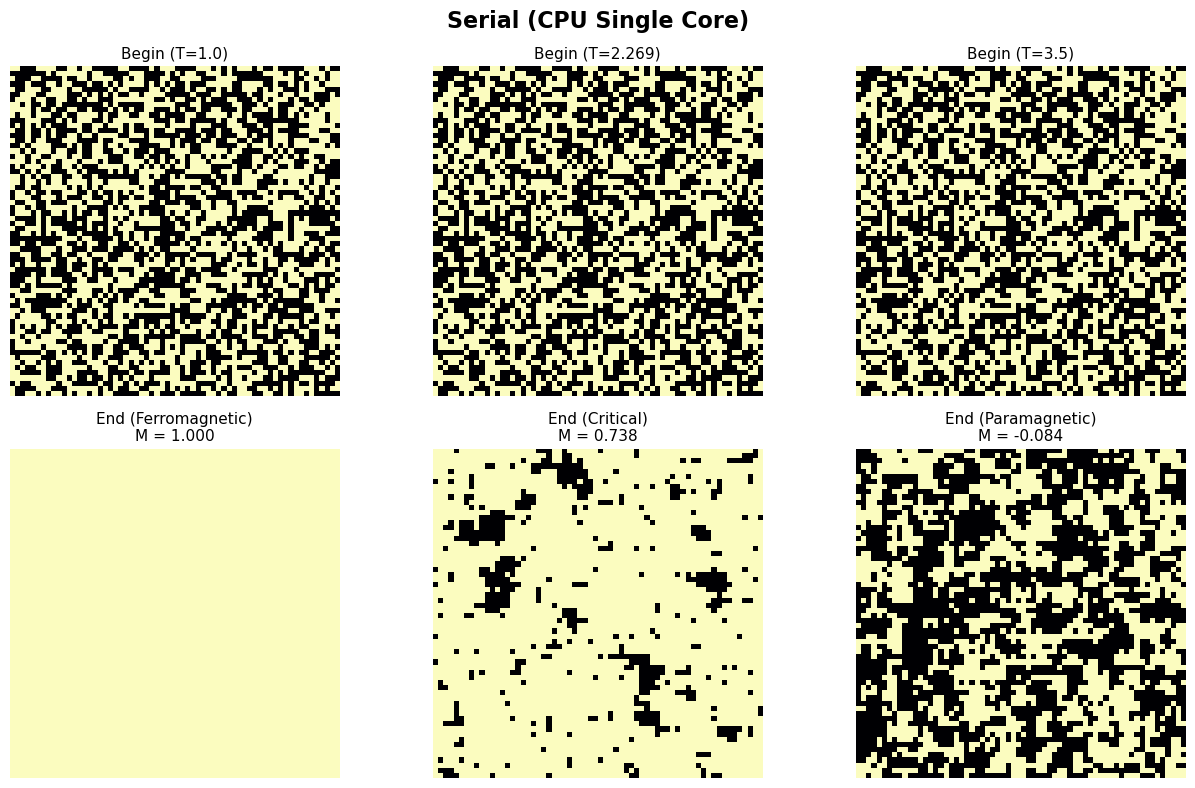

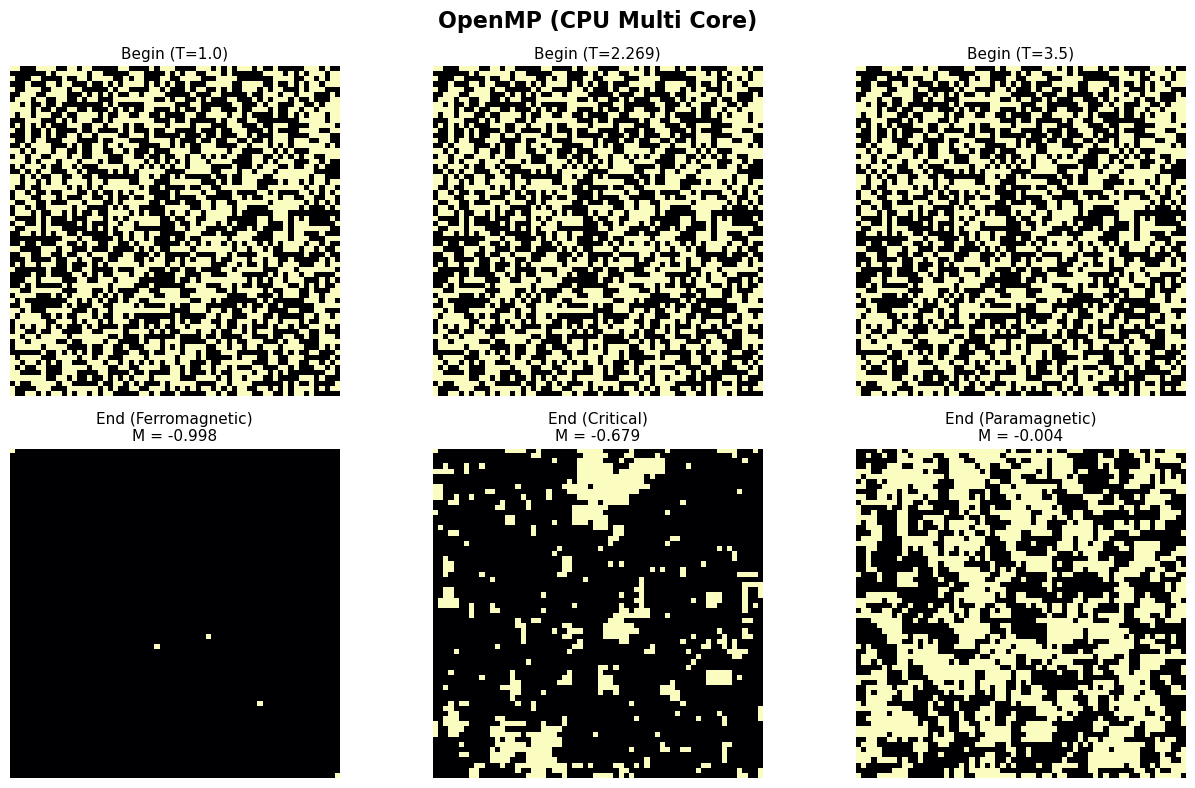

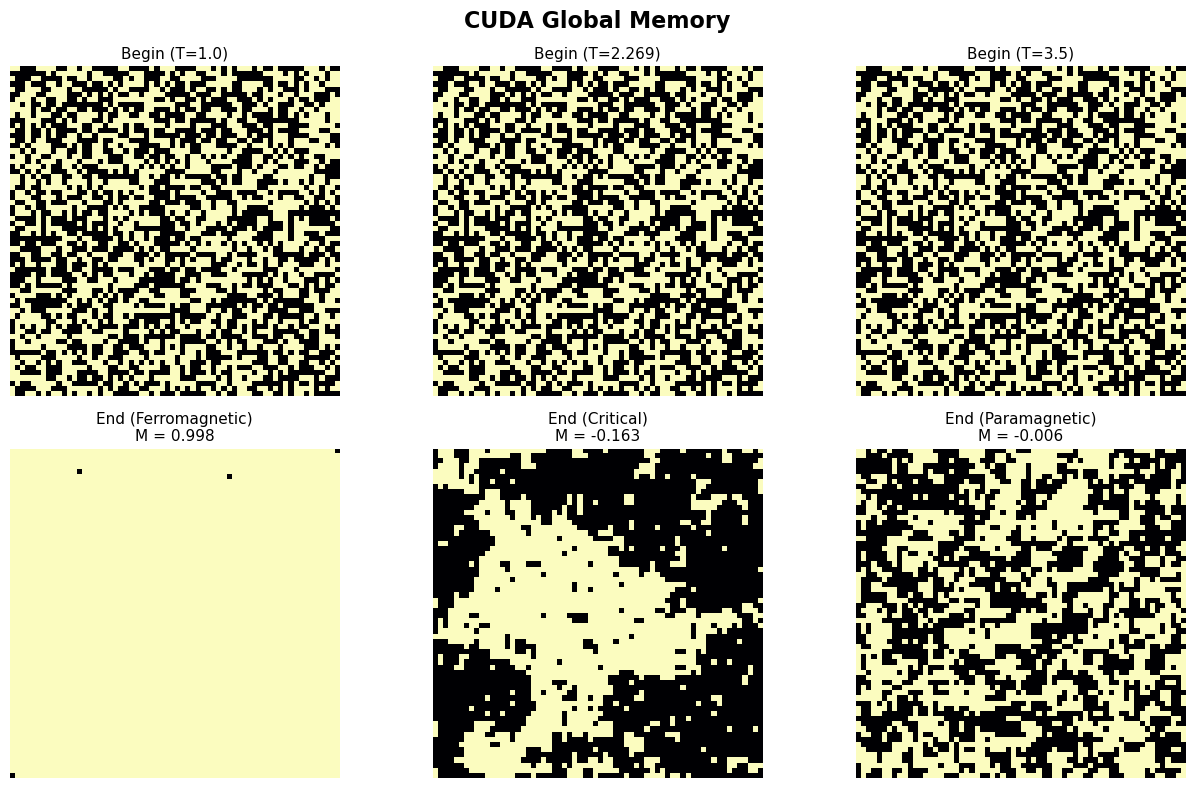

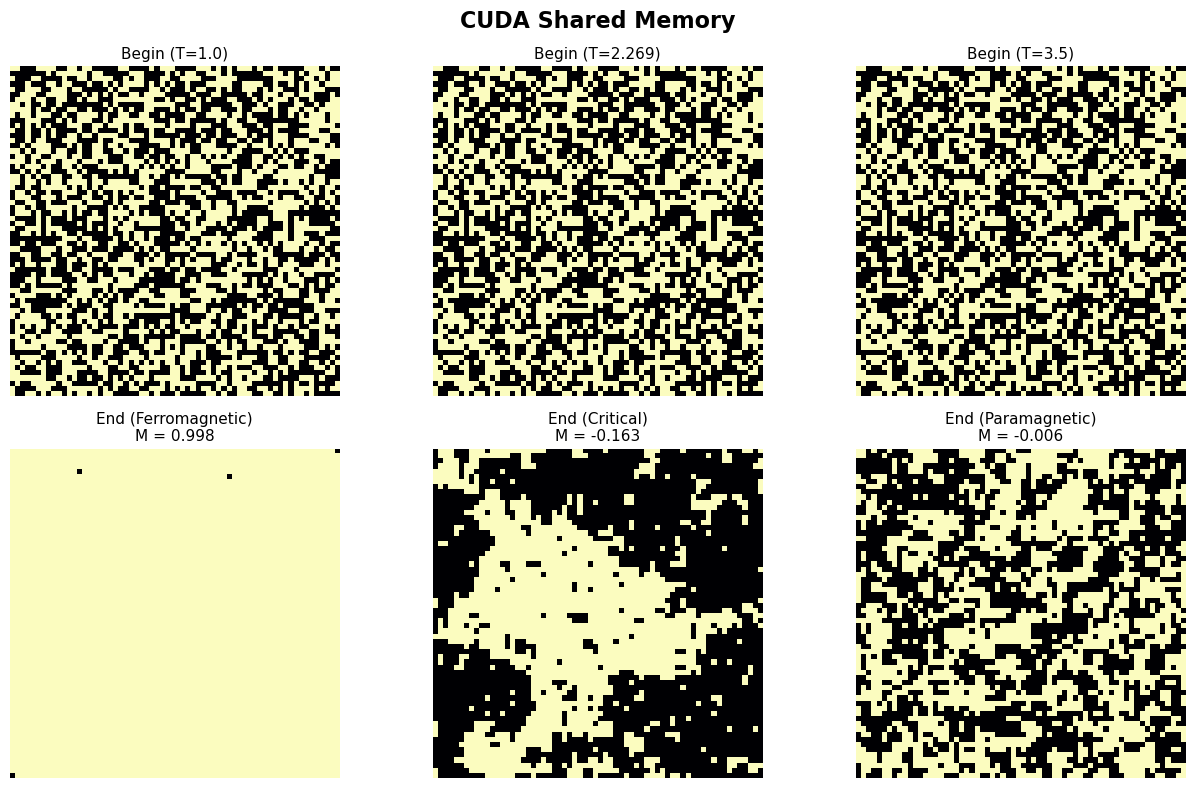

In [54]:
# Simulation data
L = 64          
STEPS = 20000   
BLOCK_SIZE = 16      

modes = [
    (ising2d.Mode.SERIAL, "Serial (CPU Single Core)"),
    (ising2d.Mode.OPENMP, "OpenMP (CPU Multi Core)"),
    (ising2d.Mode.CUDA_GLOBAL, "CUDA Global Memory"),
    (ising2d.Mode.CUDA_SHARED, "CUDA Shared Memory")
]

# temperatures to scan
temps = [1.0, 2.269, 3.5]

for mode_enum, mode_title in modes:
    # 2 rows (Begin/End), 3 columns (Temps)
    fig, ax = plt.subplots(2, 3, figsize=(13, 8))
    fig.suptitle(f"{mode_title}", fontsize=16, fontweight='bold', y=0.98)
    
    for j, T in enumerate(temps):
        
        model = ising2d.IsingModel(L, T, seed=123)
        
        # Plot Beginning configuration (Row 0)
        ax[0, j].imshow(model.lattice, cmap='magma', vmin=-1, vmax=1)
        ax[0, j].set_title(f"Begin (T={T})", fontsize=11)
        ax[0, j].axis('off')
        
        # Run simulation
        if "CUDA" in mode_title:
            model.copy_to_device()

        model.update(mode_enum, STEPS)
        
        if "CUDA" in mode_title:
            model.device_synchronize()
            model.copy_to_host()

        # Plot End configuration (Row 1)
        ax[1, j].imshow(model.lattice, cmap='magma', vmin=-1, vmax=1)
        
        # Calculate statistics
        m = np.mean(model.lattice)
        
        # titles
        phase_name = "Ferromagnetic" if T < 2.0 else "Critical" if T < 3.0 else "Paramagnetic"
        ax[1, j].set_title(f"End ({phase_name})\nM = {m:.3f}", fontsize=11)
        ax[1, j].axis('off')
        
    plt.tight_layout()
    plt.show()

### Plots |m| vs T

In [16]:
T_values = np.linspace(0.1,4.5,15)
m_values = np.ndarray((T_values.shape[0],10))
L = 64

In [17]:
def run_phase_transition_plot():
    # initial data
    L = 64 # lattice size
    SAMPLES = 10 # number of measurements per temperature
    
    # Temperature range: From 0.1 to 4.5
    T_values = np.linspace(0.1, 4.5, 20)
    
    # modest to test
    modes = [
        ("Serial(CPU)", ising2d.Mode.SERIAL),
        ("OpenMP(Multi-Core)", ising2d.Mode.OPENMP),
        ("CUDA(Global Mem)", ising2d.Mode.CUDA_GLOBAL),
        ("CUDA(Shared Mem)", ising2d.Mode.CUDA_SHARED)
    ]

    # initialize plot
    plt.figure(figsize=(8, 5))
    
    # loop over modes
    for mode_name, mode_enum in modes:
        print(f"Running: {mode_name}")
        m_means = np.zeros_like(T_values)
        m_stds  = np.zeros_like(T_values)

        # loopr over temperatures
        for i in range(T_values.shape[0]):
            T = T_values[i]
            
            # Initialize the Model
            model = ising2d.IsingModel(L=L, T=T, seed=321 + i) # Vary seed slightly for randomness
            
            # explicitly set random -1/+1 spins (to avoid metastable states at low T)
            model.lattice[:, :] = np.random.choice([-1, 1], size=(L, L))
            
            # Memory Synchronization
            # we must copy it to the GPU if we are using a CUDA mode.
            if "CUDA" in mode_name:
                model.copy_to_device()
            
            # 100k steps --> allows the system to escape metastable states (domains)
            model.update(mode_enum, steps=100000)

            # We take multiple samples to compute the average and error
            measurements = np.zeros(SAMPLES)
            
            # Take the first measurement
            if "CUDA" in mode_name:
                model.device_synchronize()
                model.copy_to_host() # Update CPU RAM to read magnetization
            
            measurements[0] = model.magnetization()

            # Take remaining measurements with gaps
            for j in range(1, SAMPLES):
                model.update(mode_enum, steps=1000) # Decorrelate samples
                
                if "CUDA" in mode_name:
                    model.device_synchronize()
                    model.copy_to_host()
                
                measurements[j] = model.magnetization()

            # compute Statistics for this Temperature
            abs_m = np.abs(measurements)
            m_means[i] = abs_m.mean()
            m_stds[i]  = abs_m.std() / np.sqrt(SAMPLES)
        
        # Plotting the results for this mode
        plt.errorbar(T_values, m_means, yerr=m_stds, fmt='-o', markersize=5, label=f'{mode_name}', alpha=0.7)
        Tc = 2.269
        plt.axvline(x=Tc, color='red', linestyle='--', label=r'$T_c$ (Theoretical)')
        plt.title(f"{mode_name} - Phase Transition (L={L}, 100k Steps)", fontsize=14)
        plt.xlabel("$T$", fontsize=12)
        plt.ylabel("$|m|$", fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.legend(fontsize=10)
        plt.ylim(-0.05, 1.1)
        
        plt.tight_layout()
        plt.savefig(f"phase_transition_{mode_name}.pdf", dpi=300)
        plt.show()

Running: Serial(CPU)


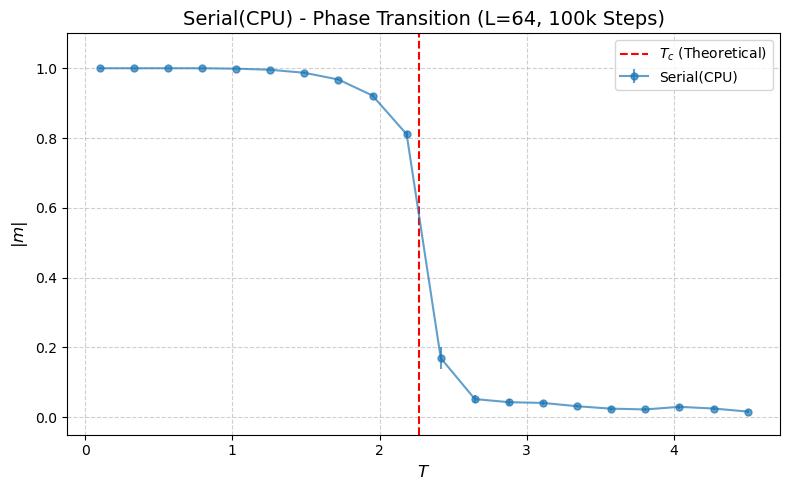

Running: OpenMP(Multi-Core)


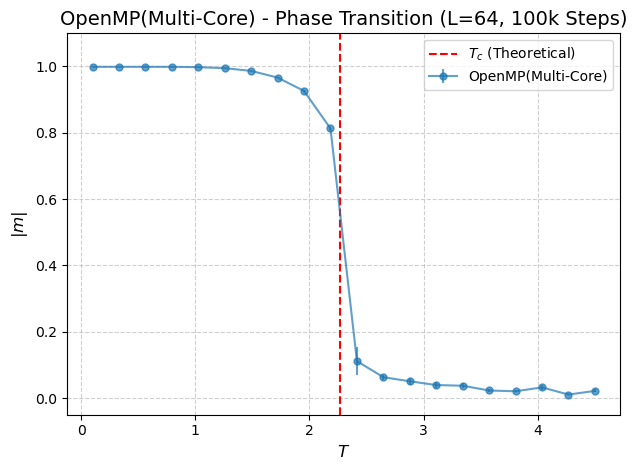

Running: CUDA(Global Mem)


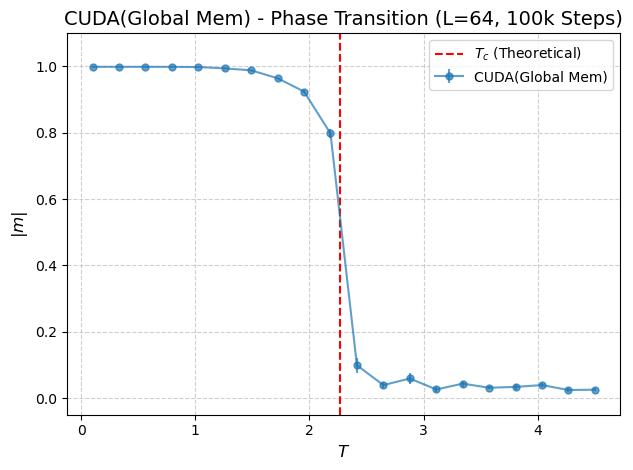

Running: CUDA(Shared Mem)


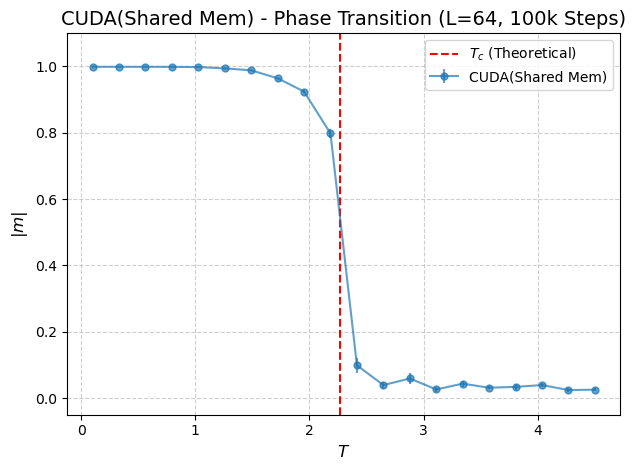

In [18]:
run_phase_transition_plot()

# Energy minimization

In [ ]:

def compare_algorithms_energy():
    L = 64           
    T = 1.0            
    J = 1.0            
    h = 0.0        
    steps_total = 20000
    measure_step = 100  
    
    modes = [
        ("Serial (CPU)",      ising2d.Mode.SERIAL),
        ("OpenMP (Multi-Core)", ising2d.Mode.OPENMP),
        ("CUDA (Global Mem)", ising2d.Mode.CUDA_GLOBAL),
        ("CUDA (Shared Mem)", ising2d.Mode.CUDA_SHARED)
    ]
    
    plt.figure(figsize=(10, 7))
    
    for mode_name, mode_enum in modes:
        print(f"   -> Testing: {mode_name}")
        
        # Identical Initialization (Fixed seed for consistency)
        model = ising2d.IsingModel(L=L, T=T, J=J, h=h, seed=123)
        
        # If it is a GPU mode, load data to device
        if "CUDA" in mode_name:
            model.copy_to_device()
            
        # Lists for plotting
        energies = []
        steps_axis = []
        
        # Initial measurement
        if "CUDA" in mode_name: # Sync before measuring
             model.copy_to_host()
             
        energies.append(model.energy() / (L*L))
        steps_axis.append(0)
        
        # Evolution Loop
        for s in range(0, steps_total, measure_step):
            # Run steps
            model.update(mode_enum, measure_step)
            
            if "CUDA" in mode_name:
                model.device_synchronize()
                model.copy_to_host()
            
            # Measure
            E = model.energy() / (L*L)
            energies.append(E)
            steps_axis.append(s + measure_step)
            
        # Plot the curve for each algorithm
        linestyle = '--' if "CUDA" in mode_name else '-'
        plt.plot(steps_axis, energies, label=f"{mode_name}", linestyle=linestyle, alpha=0.8, linewidth=2)

    plt.xlabel("Monte Carlo Steps")
    plt.ylabel("Energy per Spin ($E/N$)")
    plt.title(f"Energy Minimization (L={L})")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    
    plt.ylim(-2.1, 0.1)
    
    plt.tight_layout()
    plt.show()


   -> Testing: Serial (CPU)...
   -> Testing: OpenMP (Multi-Core)...
   -> Testing: CUDA (Global Mem)...
   -> Testing: CUDA (Shared Mem)...


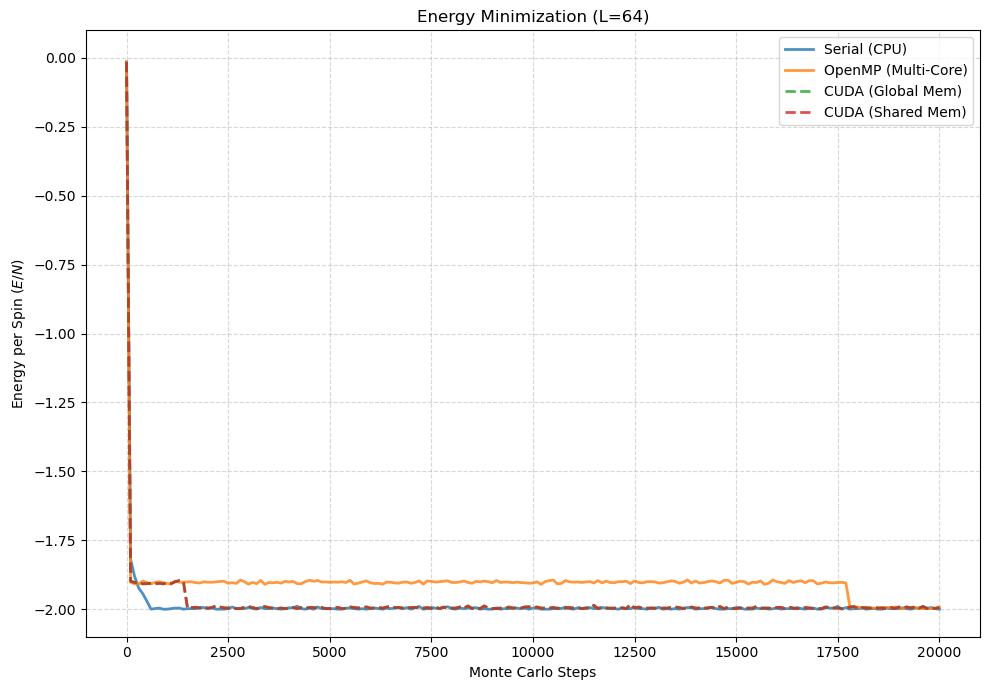

In [50]:
compare_algorithms_energy()

### Phase diagram (H,T)

In [ ]:
def plot_phase_diagram(L=64, resolution=20, steps=50000):
    """
    Generates a Heatmap of Magnetization vs Temperature and External Field.
    """
    
    # Define ranges for T (x-axis) and h (y-axis)
    T_values = np.linspace(0.1, 4.5, resolution)
    h_values = np.linspace(-2.0, 2.0, resolution)
    
    # 2D Grid to store Magnetization results
    M_grid = np.zeros((resolution, resolution))

    # Loop over Field
    for i, h in enumerate(h_values):
        # Loop over Temperature (Columns)
        for j, T in enumerate(T_values):
            
            model = ising2d.IsingModel(L, T, J = 1, h = h, seed=123 + i*j)
            
            
            # Cold Start: If h > 0, start all spins up. If h < 0, start all spins down.
            # This finds the global minimum quickly, without getting stuck in local minima of energy
            initial_spin = 1 if h >= 0 else -1
            model.lattice[:, :] = initial_spin
            
            # copy to GPU
            model.copy_to_device()
            
            # Thermalize
            model.update(ising2d.Mode.CUDA_SHARED, steps)
            
            # Measure Magnetization
            model.device_synchronize()
            model.copy_to_host()
            M_grid[i, j] = model.magnetization()

    # plotting
    plt.figure(figsize=(10, 8))
    
    plt.pcolormesh(T_values, h_values, M_grid, cmap='coolwarm', vmin=-1, vmax=1, shading='auto')
    
    # add Colorbar
    cbar = plt.colorbar()
    cbar.set_label("Magnetization $M$", rotation=270, labelpad=20, fontsize=12)
    
    plt.title(f"Ising Model Phase Diagram (L={L})", fontsize=14)
    plt.xlabel("Temperature ($T$)", fontsize=12)
    plt.ylabel("External Field ($h$)", fontsize=12)
    
    # theoretical markers
    plt.axvline(2.269, color='black', linestyle='--', alpha=0.6, label='$T_c$ (Critical Temp)')
    plt.axhline(0, color='black', linestyle=':', alpha=0.6, label='Zero Field')
    
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

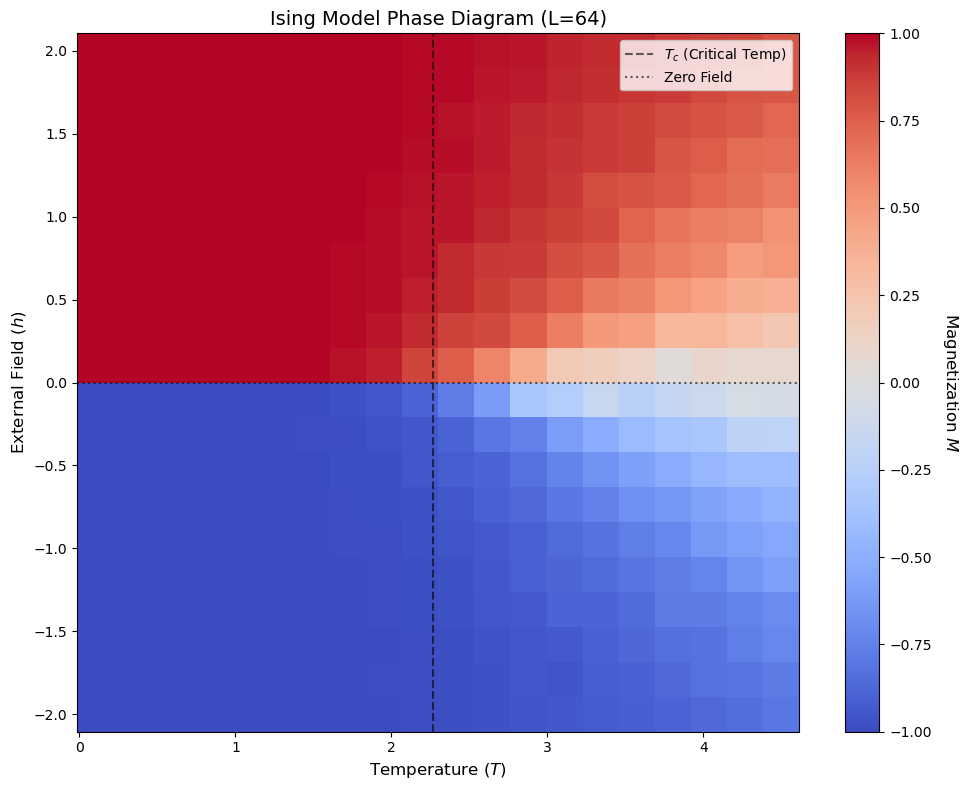

In [27]:
plot_phase_diagram()

# Performance analysis

### OpenMP - varying threads

In [4]:
L = 512
T = 2.0            
J = 1.0            
h = 0.0        
steps_total = 500
n_trials = 5

model = ising2d.IsingModel(L,T,J,h,123)
max_threads = 12

n_threads = np.arange(1,max_threads+1)          




In [10]:
import time
times_measures = np.zeros(shape=(max_threads,n_trials))

for i,n_thread in enumerate(n_threads):
    for j in range(times_measures.shape[1]):
        print(f"n_threads = {n_thread} | trial {j}", flush=True)
        model.set_num_threads(n_thread)
        
        start_time = time.perf_counter()
        model.update(ising2d.Mode.OPENMP,steps_total)
        end_time = time.perf_counter()

        times_measures[i][j] = end_time - start_time

avg_times = np.mean(times_measures,axis = 1)
std_times = np.std(times_measures, axis = 1)



n_threads = 1 | trial 0
n_threads = 1 | trial 1
n_threads = 1 | trial 2
n_threads = 1 | trial 3
n_threads = 1 | trial 4
n_threads = 2 | trial 0
n_threads = 2 | trial 1
n_threads = 2 | trial 2
n_threads = 2 | trial 3
n_threads = 2 | trial 4
n_threads = 3 | trial 0
n_threads = 3 | trial 1
n_threads = 3 | trial 2
n_threads = 3 | trial 3
n_threads = 3 | trial 4
n_threads = 4 | trial 0
n_threads = 4 | trial 1
n_threads = 4 | trial 2
n_threads = 4 | trial 3
n_threads = 4 | trial 4
n_threads = 5 | trial 0
n_threads = 5 | trial 1
n_threads = 5 | trial 2
n_threads = 5 | trial 3
n_threads = 5 | trial 4
n_threads = 6 | trial 0
n_threads = 6 | trial 1
n_threads = 6 | trial 2
n_threads = 6 | trial 3
n_threads = 6 | trial 4
n_threads = 7 | trial 0
n_threads = 7 | trial 1
n_threads = 7 | trial 2
n_threads = 7 | trial 3
n_threads = 7 | trial 4
n_threads = 8 | trial 0
n_threads = 8 | trial 1
n_threads = 8 | trial 2
n_threads = 8 | trial 3
n_threads = 8 | trial 4
n_threads = 9 | trial 0
n_threads = 9 | 

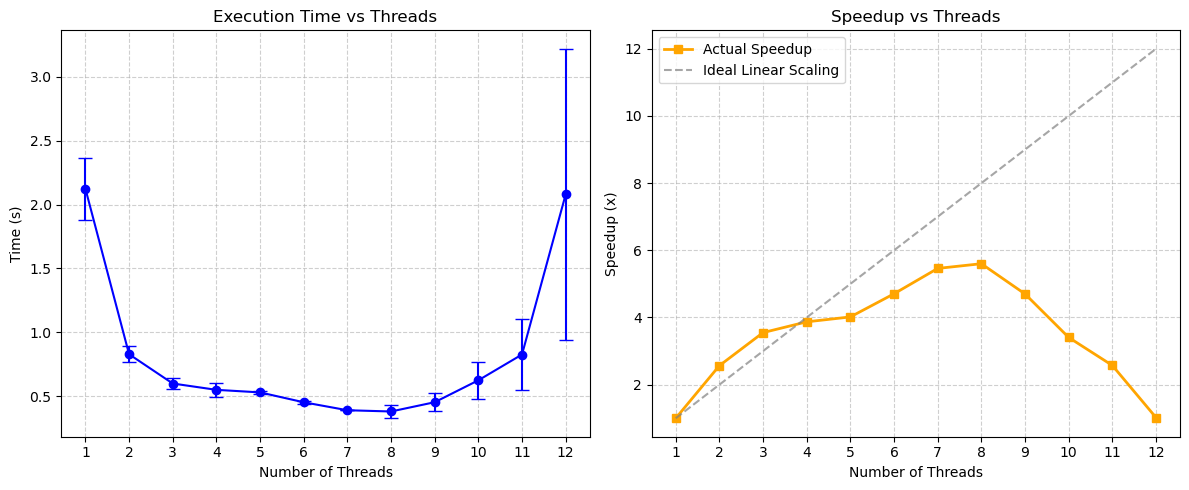

In [ ]:
avg_times = np.mean(times_measures, axis=1)
std_times = np.std(times_measures, axis=1)/np.sqrt(n_trials)

# Speedup
speedup = avg_times[0] / avg_times
ideal_speedup = n_threads 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))


# time plot
ax1.errorbar(n_threads, avg_times, yerr=std_times, fmt='-o', color='blue', capsize=5, label='Measured Time')
ax1.set_title("Execution Time vs Threads")
ax1.set_xlabel("Number of Threads")
ax1.set_ylabel("Time (s)")
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.set_xticks(n_threads)

# speedup plot
ax2.plot(n_threads, speedup, '-s', color='orange', label='Actual Speedup', linewidth=2)
ax2.plot(n_threads, ideal_speedup, '--', color='gray', label='Ideal Linear Scaling', alpha=0.7)
ax2.set_title("Speedup vs Threads")
ax2.set_xlabel("Number of Threads")
ax2.set_ylabel("Speedup (x)")
ax2.grid(True, linestyle='--', alpha=0.6)
ax2.set_xticks(n_threads)
ax2.legend()

plt.tight_layout()
plt.show()

### CUDA - varying block size

Warmup due to JIT compilation and driver resource initialization --> 1 time overhead

--> Benchmarking Lattice Size L = 512
--> Benchmarking Lattice Size L = 2048
--> Benchmarking Lattice Size L = 4096


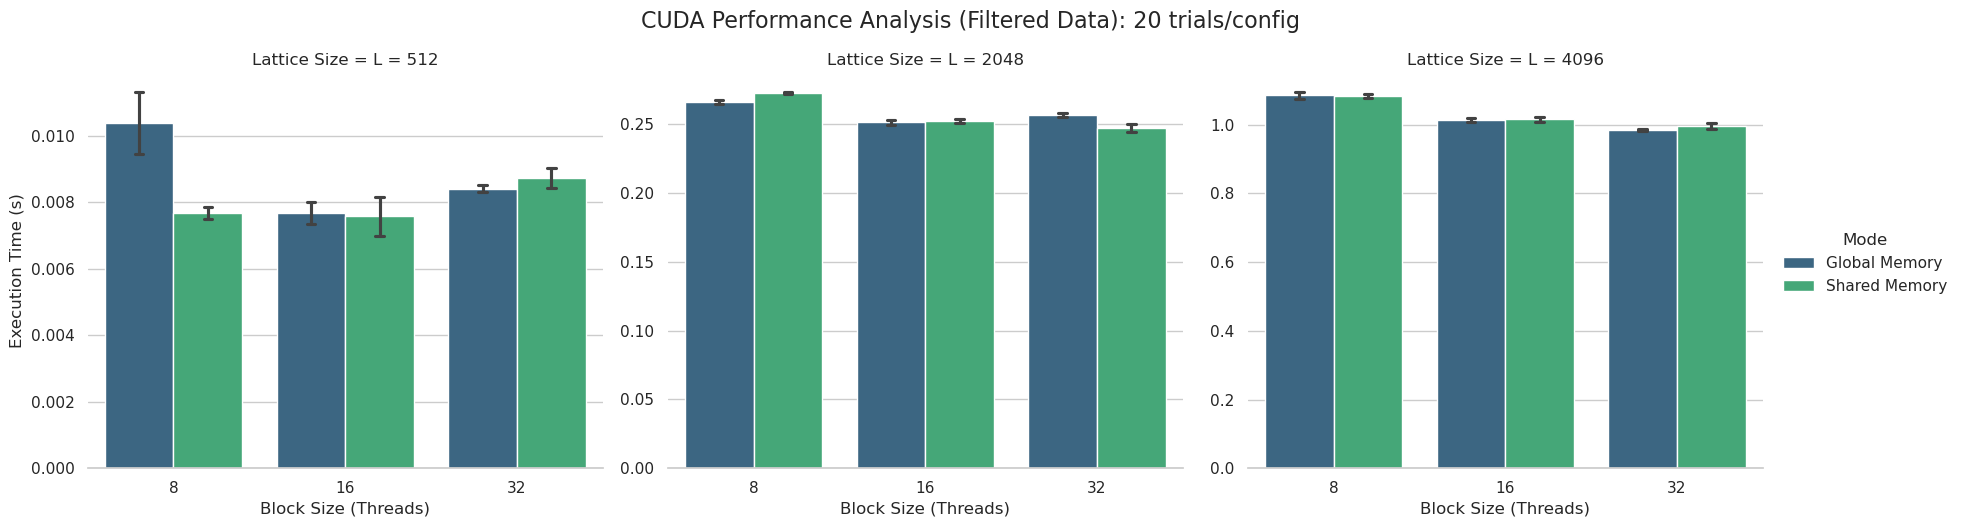

In [ ]:
# data

L_values = [512, 2048, 4096]
block_sizes = [8, 16, 32]
steps_total = 100
T, J, h = 1.0, 1.0, 0.0  

# We use a warm-up phase to allow the GPU to reach stable clock speeds 
# and the to initialize resources.
n_warmup_trials = 10     # Discard first 5 trials (Transient state)
n_measure_trials = 20  # Keep the following 10 trials (Steady state)
total_trials = n_warmup_trials + n_measure_trials

# CUDA implementation modes to compare
modes = [ising2d.Mode.CUDA_GLOBAL, ising2d.Mode.CUDA_SHARED]
mode_names = ['Global Memory', 'Shared Memory']

data_records = []

for L in L_values:
    print(f"--> Benchmarking Lattice Size L = {L}")
    # Initialize the Ising Model
    model = ising2d.IsingModel(L, T, J, h, 123)

    for mode, key in zip(modes, mode_names):
        for bs in block_sizes:
            # Set the thread block dimensions (bs x bs)
            model.set_cuda_block_size(bs)
            
            # Initial kernel warm-up to ensure GPU is ready
            model.update(mode, steps=10)
            model.device_synchronize()

            for j in range(total_trials):
                # Synchronize device to ensure timing only covers current execution
                model.device_synchronize()
                
                start = time.perf_counter()
                model.update(mode, steps_total)
                # Essential: synchronize again to wait for asynchronous GPU kernels to finish
                model.device_synchronize()
                end = time.perf_counter()
                
                total_time = end - start
                
                # --- DATA FILTERING ---
                # We only record measurements taken after the warm-up trials
                if j >= n_warmup_trials:
                    data_records.append({
                        "Lattice Size": f"L = {L}",
                        "Mode": key,
                        "Block Size": bs,
                        "Time (s)": total_time
                    })

# Create DataFrame for plotting
df = pd.DataFrame(data_records)
# Plots
sns.set_theme(style="whitegrid")

# Create a categorical plot to compare Global vs Shared memory performance
g = sns.catplot(
    data=df,
    kind="bar",
    x="Block Size",
    y="Time (s)",
    hue="Mode",
    col="Lattice Size",
    palette="viridis",
    height=5,
    aspect=1.2,
    capsize=.1,
    errorbar="sd",  
    sharey=False    
)

# Set titles and labels
g.figure.suptitle(f"CUDA Performance Analysis+: {n_measure_trials} trials/config", y=1.05, fontsize=16)
g.set_axis_labels("Block Size (Threads)", "Execution Time (s)")
g.despine(left=True)

plt.show()

### Time execution & spin updates per second

In [ ]:
L_list = [64,128,256,512,1024]           
T = 2.0            
J = 1.0            
h = 0.0        
steps_total = 1000
n_trials = 5

modes = [ising2d.Mode.SERIAL, ising2d.Mode.OPENMP, ising2d.Mode.CUDA_GLOBAL, ising2d.Mode.CUDA_SHARED]

modes_times = {'Serial':[], 'OpenMP':[], 'Cuda(Global)':[],'Cuda(Shared)':[]}

for mode_enum, key in zip(modes, modes_times.keys()):
    print(f"Benchmarking {key}")
    
    for L in L_list:
        
        model = ising2d.IsingModel(L, T, J, h, seed=123)
        
        for i in range(n_trials):
            
            if 'Cuda' in key:
                model.device_synchronize()

            start_time = time.perf_counter()
            
            model.update(mode_enum, steps_total)
            
            if 'Cuda' in key:
                model.device_synchronize()
               
            end_time = time.perf_counter()

            total_time = end_time - start_time
            modes_times[key].append(total_time)

In [ ]:
import pandas as pd
import seaborn as sns


data_for_plot = []

for mode, times in modes_times.items():
    idx = 0
    for L in L_list:
        for _ in range(n_trials):
            if idx < len(times):
                data_for_plot.append({'L': L, 'Time': times[idx], 'Mode': mode})
                idx += 1

df = pd.DataFrame(data_for_plot)

plt.figure(figsize=(10, 6))

sns.barplot(data=df, x='L', y='Time', hue='Mode', errorbar='sd', palette='Paired') 

plt.yscale('log')
plt.grid(True, axis='y', alpha=0.3)
plt.title("Ising 2D Performance Benchmark")
plt.show()

In [ ]:
df_results = df.groupby(['Mode','L'])['Time'].mean()